In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import config
import numpy as np
from models import ResNet, ConvBlock, ShuffleNetV2
from utils import *
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchsummary import summary
from tqdm import notebook
tqdm = notebook.tqdm

CIFAR10 Dataset and Dataloader

In [2]:
train_dataset = CIFAR10("CIFAR10", train=True, transform=tranform)
test_dataset = CIFAR10("CIFAR10", train=False, transform=tranform)
loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, pin_memory=True, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, pin_memory=True, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)


To achieve our task on exploring different hyperparameters' effect on model, we define a simple convolutional neural networks below.
It has three hidden layers(two convolution layers and a fully connected layer at the end).
Each conv layer has a pooling layer and an activation function at the end.
Adding batchnorm or switching activation function by hyperparameters.

In the upcoming section, we will train this model with a list of different parameters, then compare their different in performance.

In [3]:
#Define a simple conv net
class Convs(nn.Module):
    def __init__(self, img_channels=3, img_size=32, num_filters=[64, 128], pooling="max", num_classes=10, dropout=None, **kwargs):
        '''
        Random established convolutional neural network

        :param img_channels: channels of inout images
        :param num_classes: number of classes from dataset
        :param num_filters: number of filters used by Convblock in model
        :param dropout: Dropout rate of dropout layer before fully connected layers
        :param kwargs: Batchnorm, activation function and initialization of ConvBlock
        '''
        super().__init__()
        self.in_channels = num_filters[0]
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) if pooling == "max" else nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.init = nn.Sequential(
            ConvBlock(img_channels, self.in_channels, kernel_size=3, stride=2, padding=1, **kwargs),
            self.pooling
        )
        img_size /= 4
        layers = []
        for filter in num_filters[1:]:
            layers.append(ConvBlock(self.in_channels, filter, kernel_size=3, stride=1, padding=1,**kwargs))
            layers.append(self.pooling)
            self.in_channels = filter
            img_size /= 2
        self.main = nn.Sequential(*layers)
        layers = []
        layers.append(nn.Flatten())
        layers.append(nn.Dropout(dropout)) if dropout else None
        layers.append(nn.Linear(int(num_filters[-1]*(img_size**2)), num_classes))
        self.output = nn.Sequential(*layers)

    def forward(self, x):
        x = self.init(x)
        x = self.main(x)
        return self.output(x)


model = Convs(use_bn=False).to(config.DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
summary(model,(3,32,32))
#Save a torchscript for Netron's graph
traced = torch.jit.trace(model, torch.randn(2,3,32,32).to(config.DEVICE))
traced.save("result/model.pt")

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
            Conv2d-2           [-1, 64, 16, 16]           1,792
              ReLU-3           [-1, 64, 16, 16]               0
              ReLU-4           [-1, 64, 16, 16]               0
         ConvBlock-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
           Conv2d-10            [-1, 128, 8, 8]          73,856
             ReLU-11            [-1, 128, 8, 8]               0
             ReLU-12            [-1, 128, 8, 8]               0
        ConvBlock-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

In [4]:
#Hyperparameters
epochs = 20
width = 0.4



K Fold Validation of Convs


In [5]:
conv_acc_list=[]
for i in range(6):
    print(f"Evaulating epoch {i}:")
    acc = KFold_validation(model, train_dataset, shuffle=False, val_epochs=i, split=config.KFOLD_SPLIT, lr=config.LEARNING_RATE)
    conv_acc_list.append(sum(acc)/len(acc))

torch.save(conv_acc_list, "result/conv_kfold_acc_list.tar")

Evaulating epoch 0:


Testing:[5]: 100%|██████████| 40/40 [00:02<00:00, 14.53it/s, accuracy=0.102, loss=2.34]


Evaulating epoch 1:


Testing:[5]: 100%|██████████| 40/40 [00:02<00:00, 15.63it/s, accuracy=0.44, loss=1.19] 


Evaulating epoch 2:


Testing:[5]: 100%|██████████| 40/40 [00:02<00:00, 15.69it/s, accuracy=0.494, loss=1.33]


Evaulating epoch 3:


Testing:[5]: 100%|██████████| 40/40 [00:02<00:00, 14.31it/s, accuracy=0.528, loss=1.77]


Evaulating epoch 4:


Testing:[5]: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s, accuracy=0.561, loss=1.05]


Evaulating epoch 5:


Testing:[5]: 100%|██████████| 40/40 [00:02<00:00, 16.07it/s, accuracy=0.575, loss=1.72]


Loss curve of Convs

In [6]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_curve.tar")


Testing:[200]: 100%|██████████| 40/40 [00:04<00:00,  8.19it/s, accuracy=0.713, loss=0.644] 


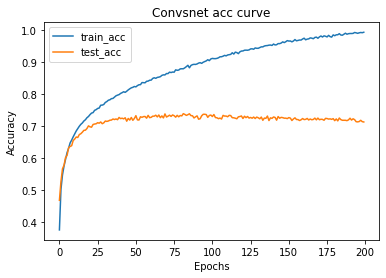

In [7]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()



Loss curve of Convs training on 1e-2 and 1e-6


Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 10.98it/s, accuracy=0.569, loss=1.98] 


Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s, accuracy=0.445, loss=1.82]


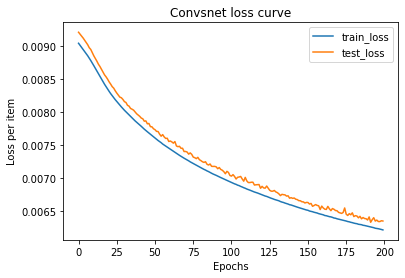

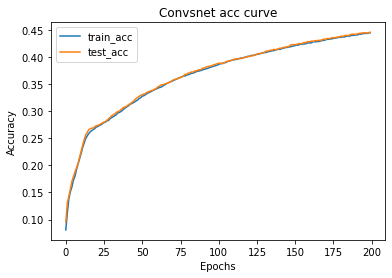

In [8]:
#1e-2 learning rate
model = Convs(use_bn=False).to(config.DEVICE)
train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=1e-2)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/1e-2_curve.tar")

#ploting result
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()

#1e-6 learning rate
model = Convs(use_bn=False).to(config.DEVICE)
train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=1e-6)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)

#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/1e-6_curve.tar")

#plotting result
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()

Curve of Convs with BatchNorm in batch 32 and 256.


Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 10.94it/s, accuracy=0.72, loss=0.388]


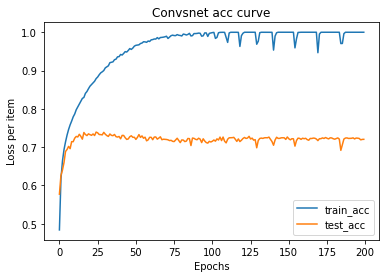

Testing:[200]: 100%|██████████| 625/625 [00:05<00:00, 111.06it/s, accuracy=0.72, loss=3.37]     


In [9]:
#Batch 256
model = Convs(use_bn=True).to(config.DEVICE)
train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/batch256norm.tar")

#ploting result
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()

model = Convs(use_bn=True).to(config.DEVICE)
loader_16batch = DataLoader(train_dataset, batch_size=16, pin_memory=True, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)
test_loader_16batch = DataLoader(test_dataset, batch_size=16, pin_memory=True, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader_16batch, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader_16batch, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/batch16norm.tar")

#ploting result
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()

Curve of models with Tanh activation

In [10]:
model = Convs(use_bn=False, activation=nn.Tanh()).to(config.DEVICE)
traced = torch.jit.trace(model, torch.randn(2,3,32,32).to(config.DEVICE))
traced.save("result/convs_tanh.pt")

train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_tanh.tar")

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 11.08it/s, accuracy=0.727, loss=0.568]


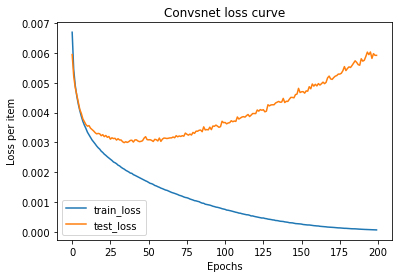

In [11]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()


Curve of average pooling

In [12]:
model = Convs(use_bn=False,pooling="avg").to(config.DEVICE)
summary(model,(3,32,32))
traced = torch.jit.trace(model, torch.randn(2,3,32,32).to(config.DEVICE))
traced.save("result/convs_avg.pt")

train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_avg.tar")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
            Conv2d-2           [-1, 64, 16, 16]           1,792
              ReLU-3           [-1, 64, 16, 16]               0
              ReLU-4           [-1, 64, 16, 16]               0
         ConvBlock-5           [-1, 64, 16, 16]               0
         AvgPool2d-6             [-1, 64, 8, 8]               0
         AvgPool2d-7             [-1, 64, 8, 8]               0
         AvgPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
           Conv2d-10            [-1, 128, 8, 8]          73,856
             ReLU-11            [-1, 128, 8, 8]               0
             ReLU-12            [-1, 128, 8, 8]               0
        ConvBlock-13            [-1, 128, 8, 8]               0
        AvgPool2d-14            [-1, 12

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 11.07it/s, accuracy=0.732, loss=0.996]


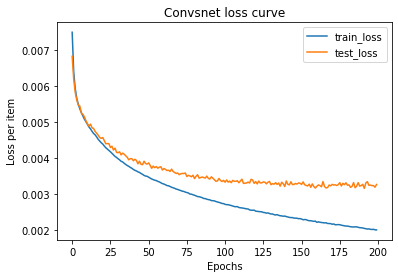

In [13]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()


Curve of two different initialization( also Xavier with TanH)

In [14]:

model = Convs(use_bn=False, init="He").to(config.DEVICE)
traced = torch.jit.trace(model, torch.randn(2,3,32,32).to(config.DEVICE))

train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_tanh.tar")

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 10.98it/s, accuracy=0.706, loss=1.79]  


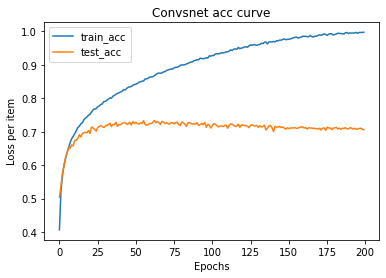

In [15]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()




In [16]:
model = Convs(use_bn=False, init="Xavier").to(config.DEVICE)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_Xavier_initialization.pt.tar")

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 11.16it/s, accuracy=0.709, loss=1.41]  


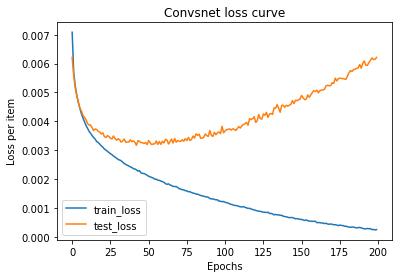

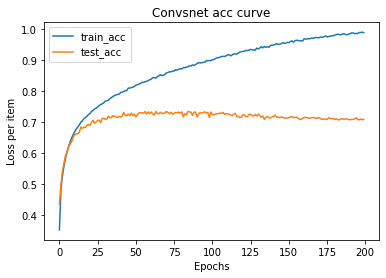

In [17]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()

In [18]:
model = Convs(use_bn=False, init="Xavier").to(config.DEVICE)
summary(model,(3,32,32))
# traced = torch.jit.trace(model, torch.randn(2,3,32,32).to(config.DEVICE))
# traced.save("result/convs_Xavier_initialization.pt")

train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_Xavier_initialization.tar")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
            Conv2d-2           [-1, 64, 16, 16]           1,792
              ReLU-3           [-1, 64, 16, 16]               0
              ReLU-4           [-1, 64, 16, 16]               0
         ConvBlock-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
           Conv2d-10            [-1, 128, 8, 8]          73,856
             ReLU-11            [-1, 128, 8, 8]               0
             ReLU-12            [-1, 128, 8, 8]               0
        ConvBlock-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 10.87it/s, accuracy=0.708, loss=1.11]  


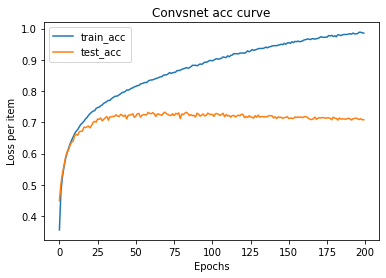

In [19]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()


In [20]:

model = Convs(use_bn=False, init="Xavier", activation=nn.Tanh()).to(config.DEVICE)
summary(model,(3,32,32))
traced = torch.jit.trace(model, torch.randn(2,3,32,32).to(config.DEVICE))
traced.save("result/convs_Xavier_initialization_tanh.pt")

train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_Xavier_initialization_tanh.tar")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
            Conv2d-2           [-1, 64, 16, 16]           1,792
              Tanh-3           [-1, 64, 16, 16]               0
              Tanh-4           [-1, 64, 16, 16]               0
         ConvBlock-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
           Conv2d-10            [-1, 128, 8, 8]          73,856
             Tanh-11            [-1, 128, 8, 8]               0
             Tanh-12            [-1, 128, 8, 8]               0
        ConvBlock-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 11.18it/s, accuracy=0.727, loss=1.3]  


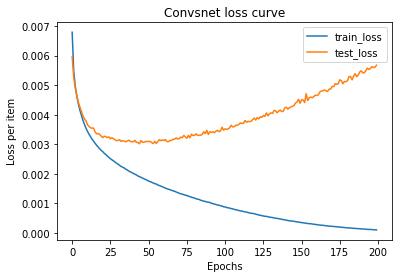

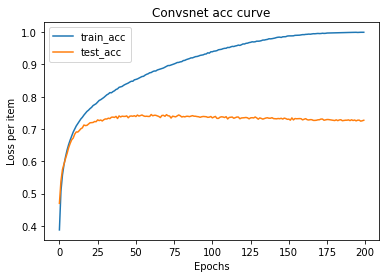

In [21]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()

Loss curve with 0.2, 0.5 and 0.7 dropout rate in fully connected layer

In [22]:
model = Convs(use_bn=False, dropout=0.2).to(config.DEVICE)
summary(model,(3,32,32))
traced = torch.jit.trace(model, torch.randn(2,3,32,32).to(config.DEVICE))
traced.save("result/convs_dropout0.2.pt")

train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_dropout0.2.tar")

D:\Anaconda\envs\pytorch\lib\site-packages\torch\jit\_trace.py:977: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 20 element(s) (out of 20) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.4672074392437935 (0.08776228874921799 vs. 0.5549697279930115), which occurred at index (0, 4).
  _check_trace(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
            Conv2d-2           [-1, 64, 16, 16]           1,792
              ReLU-3           [-1, 64, 16, 16]               0
              ReLU-4           [-1, 64, 16, 16]               0
         ConvBlock-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
           Conv2d-10            [-1, 128, 8, 8]          73,856
             ReLU-11            [-1, 128, 8, 8]               0
             ReLU-12            [-1, 128, 8, 8]               0
        ConvBlock-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 11.15it/s, accuracy=0.723, loss=1.06] 


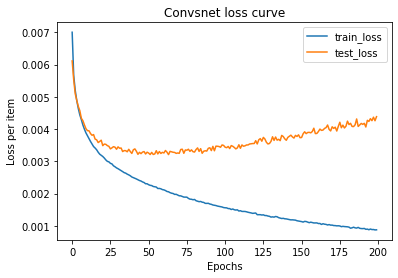

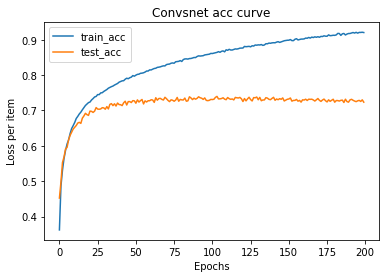

In [23]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()

In [24]:
model = Convs(use_bn=False, dropout=0.5).to(config.DEVICE)
summary(model,(3,32,32))


train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_dropout0.5.tar")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
            Conv2d-2           [-1, 64, 16, 16]           1,792
              ReLU-3           [-1, 64, 16, 16]               0
              ReLU-4           [-1, 64, 16, 16]               0
         ConvBlock-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
           Conv2d-10            [-1, 128, 8, 8]          73,856
             ReLU-11            [-1, 128, 8, 8]               0
             ReLU-12            [-1, 128, 8, 8]               0
        ConvBlock-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 11.06it/s, accuracy=0.719, loss=0.421]


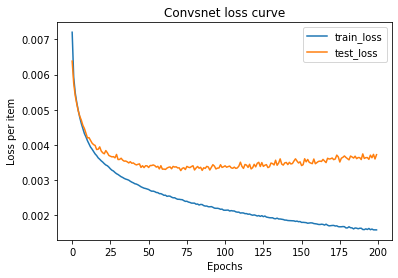

In [25]:

plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()

In [26]:
model = Convs(use_bn=False, dropout=0.7).to(config.DEVICE)
summary(model,(3,32,32))


train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_dropout0.7.tar")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
            Conv2d-2           [-1, 64, 16, 16]           1,792
              ReLU-3           [-1, 64, 16, 16]               0
              ReLU-4           [-1, 64, 16, 16]               0
         ConvBlock-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
           Conv2d-10            [-1, 128, 8, 8]          73,856
             ReLU-11            [-1, 128, 8, 8]               0
             ReLU-12            [-1, 128, 8, 8]               0
        ConvBlock-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 11.03it/s, accuracy=0.703, loss=0.434]


In [27]:

plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()

loss curve of convs with two additional conv layers

In [28]:
model = Convs(use_bn=False, num_filters=[64, 128, 256, 512]).to(config.DEVICE)
summary(model,(3,32,32))
traced = torch.jit.trace(model, torch.randn(2,3,32,32).to(config.DEVICE))
traced.save("result/convs_5_hiddens.pt")


train_loss = []
test_loss = []
train_acc = []
test_acc = []
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
for epoch in range(200):
    acc, loss = train(model, optimizer, loader, epoch)
    train_loss.append(loss)
    train_acc.append(acc)
    acc, loss = test(model, test_loader, epoch)
    test_loss.append(loss)
    test_acc.append(acc)
#Save the result
torch.save((train_loss, test_loss, train_acc, test_acc), "result/convs_5_hiddens.tar")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
            Conv2d-2           [-1, 64, 16, 16]           1,792
              ReLU-3           [-1, 64, 16, 16]               0
              ReLU-4           [-1, 64, 16, 16]               0
              ReLU-5           [-1, 64, 16, 16]               0
              ReLU-6           [-1, 64, 16, 16]               0
         ConvBlock-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
           Conv2d-12            [-1, 128, 8, 8]          73,856
             ReLU-13            [-1, 128, 8, 8]               0
             ReLU-14            [-1, 12

Testing:[200]: 100%|██████████| 40/40 [00:03<00:00, 10.34it/s, accuracy=0.729, loss=1.59]   


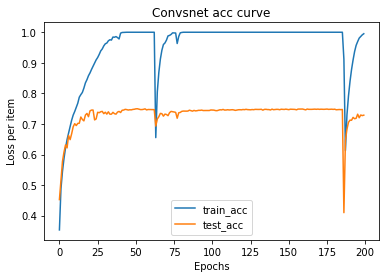

In [29]:

plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet loss curve")
plt.legend()
plt.show()

plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.xlabel("Epochs")
plt.ylabel("Loss per item")
plt.title("Convsnet acc curve")
plt.legend()
plt.show()